In [4]:
## Imports

import sys
import os
import time
import math
import random
import pdb
import h5py

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if par_dir not in sys.path:
    sys.path.append(par_dir)
    
# Plotting import
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import the utils for plotting the metrics
from plot_utils import plot_utils
from plot_utils import notebook_utils_2

from sklearn.metrics import roc_curve, auc

In [5]:
# Fix the colour scheme for each particle type
COLOR_DICT = {"gamma":"red", "e":"blue", "mu":"green"}

In [6]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [7]:
def plot_multiple_ROC(fprs, tprs, thresholds, label_0, label_1, lbound, ubound, interval):
    
    min_energy = 0
    max_energy = 1000
    
    fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
    ax.tick_params(axis="both", labelsize=20)
    
    model_colors = [np.random.rand(3,) for i in fprs]
    
    for j in np.arange(len(fprs)):
        fpr = fprs[j]
        tpr = tprs[j]
        threshold = thresholds[j]
     
        roc_auc = auc(fpr, tpr)

        inv_fpr = []
        for i in fpr:
            inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-5)

        tnr = 1. - fpr

        # TNR vs TPR plot

        ax.plot(tpr, inv_fpr, color=model_colors[j],
                 label=r"Interval ${1:0.3f}$: $\{0}$, AUC ${1:0.3f}$".format((j+1),label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
                 linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=model_colors[j])

        # Show coords of individual points near x = 0.2, 0.5, 0.8
        todo = {0.2: True, 0.5: True, 0.8: True}
        for xy in zip(tpr, inv_fpr, tnr):
            xy = (round(xy[0], 4), round(xy[1], 4), round(xy[2], 4))
            xy_plot = (round(xy[0], 4), round(xy[1], 4))
            for point in todo.keys():
                if xy[0] >= point and todo[point]:
                    #ax.annotate('(%s, %s, %s)' % xy, xy=xy_plot, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                    todo[point] = False

            ax.grid(True, which='both', color='grey')
            xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
            ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

            ax.set_xlabel(xlabel, fontsize=20) 
            ax.set_ylabel(ylabel, fontsize=20)

            ax.set_title(r"${0} \leq E < {1}$".format(round(lbound,2), round(ubound,2)), fontsize=20)
            ax.legend(loc="upper right", prop={"size":20})

            plt.margins(0.1)
        plt.yscale("log")
        
    plt.savefig(('/home/ttuinstr/VAE/debugging/ROC_' + str(interval) + '.png'), bbox_inches='tight')    
    
    plt.show()

    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

In [8]:
def plot_ROC(fpr, tpr, threshold, label_0, label_1, lbound, ubound, interval, step):
    
    min_energy = 0
    max_energy = 1000
    
    roc_auc = auc(fpr, tpr)
    
    inv_fpr = []
    for i in fpr:
        inv_fpr.append(1/i) if i != 0 else inv_fpr.append(1/1e-5)
        
    tnr = 1. - fpr
 
    # TNR vs TPR plot
    fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
    ax.tick_params(axis="both", labelsize=20)

    ax.plot(tpr, inv_fpr, color=COLOR_DICT[label_1],
             label=r"$\{0}$, AUC ${1:0.3f}$".format(label_0, roc_auc) if label_0 is not "e" else r"${0}$, AUC ${1:0.3f}$".format(label_0, roc_auc),
             linewidth=1.0, marker=".", markersize=4.0, markerfacecolor=COLOR_DICT[label_1])

    # Show coords of individual points near x = 0.2, 0.5, 0.8
    todo = {0.2: True, 0.5: True, 0.8: True}
    for xy in zip(tpr, inv_fpr, tnr):
        xy = (round(xy[0], 4), round(xy[1], 4), round(xy[2], 4))
        xy_plot = (round(xy[0], 4), round(xy[1], 4))
        for point in todo.keys():
            if xy[0] >= point and todo[point]:
                ax.annotate('(%s, %s, %s)' % xy, xy=xy_plot, textcoords='data', fontsize=18, bbox=dict(boxstyle="square", fc="w"))
                todo[point] = False

        ax.grid(True, which='both', color='grey')
        xlabel = r"$\{0}$ signal efficiency".format(label_0) if label_0 is not "e" else r"${0}$ signal efficiency".format(label_0)
        ylabel = r"$\{0}$ background rejection".format(label_1) if label_1 is not "e" else r"${0}$ background rejection".format(label_1)

        ax.set_xlabel(xlabel, fontsize=20) 
        ax.set_ylabel(ylabel, fontsize=20)

        ax.set_title(r"${0} \leq E < {1}$".format(round(lbound,2), round(ubound,2)), fontsize=20)
        ax.legend(loc="upper right", prop={"size":20})
        
        plt.margins(0.1)
        plt.yscale("log")
        
    plt.savefig(('/home/ttuinstr/VAE/debugging/ROC_' + str(interval) + '_' + str(step) + '.png'), bbox_inches='tight')    
    
    plt.show()

    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return fpr, tpr, threshold, roc_auc

In [9]:
def plot_rej_pos(fprs, tprs, thresholds, label_0, label_1, lbound, ubound, interval, efficiency, bins):
    
    min_pos = 0
    max_pos = 720
    
    fig, ax = plt.subplots(figsize=(16,9),facecolor="w")
    ax.tick_params(axis="both", labelsize=20)
    
    model_colors = [np.random.rand(3,) for i in fprs]
    
    eff_invfpr = np.array([])
    
    error = []
    
    for j in np.arange(len(fprs)):
        fpr = fprs[j]
        tpr = tprs[j]
        threshold = thresholds[j]
     
        roc_auc = auc(fpr, tpr)

        inv_fpr = np.array([])
        for i in fpr:
            if i != 0:
                inv_fpr = np.append(inv_fpr, (1/i))
            else:
                inv_fpr = np.append(inv_fpr, (1/1e-5))

        tnr = 1. - fpr
        
        eff_index = np.where(np.around(tpr, decimals=2) == 0.8)[0].astype(int)
        eff_invfpr = np.append(eff_invfpr, inv_fpr[eff_index].mean())
        
        error.append(inv_fpr[eff_index].std())
        
    # TNR vs Energy bin plot
    label = 0
    ax.bar(bins, yerr=error, height=eff_invfpr, width=-interval, color="green", align='edge')
    ax.legend()
    ax.set_ylabel("Muon background rejection", fontsize=20)

    plt.xlabel("Distance from Center of Tank (cm)", fontsize=20)
    
    
    ax.set_title("Rejection vs. Distance from Center at " + str(efficiency) + " Efficiency", fontsize=20)
    
    plt.yscale("log")
        
    plt.savefig(('/home/ttuinstr/VAE/debugging/RejectionEnergyBinning_' + str(efficiency) + "_" +  str(interval) + '.png'), bbox_inches='tight')    
    
    plt.show()

    plt.clf() # Clear the current figure
    plt.close() # Close the opened window
        
        
    return eff_invfpr, threshold, roc_auc

In [10]:
# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")
original_eventids = np.array(f['event_ids'])
original_rootfiles = np.array(f['root_files'])
original_energies = np.array(f['energies'])
original_positions = np.array(f['positions'])
original_angles = np.array(f['angles'])
filtered_eventids = original_eventids[test_filtered_indices]
filtered_rootfiles = original_rootfiles[test_filtered_indices]
filtered_energies = original_energies[test_filtered_indices]
filtered_positions = original_positions[test_filtered_indices]
filtered_angles = original_angles[test_filtered_indices]


# Map test events to fiTQun events

# First, separate event types
e_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_e.npz')
e_test_indices = e_test_indices['arr_0'].astype(int)
mu_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_mu.npz')
mu_test_indices = mu_test_indices['arr_0'].astype(int)
gamma_test_indices = np.load('/home/ttuinstr/VAE/debugging/test_indices_gamma.npz')
gamma_test_indices = gamma_test_indices['arr_0'].astype(int)

e_positions = filtered_positions[e_test_indices]
mu_positions = filtered_positions[mu_test_indices]
gamma_positions = filtered_positions[gamma_test_indices]

e_angles = filtered_angles[e_test_indices]
mu_angles = filtered_angles[mu_test_indices]
gamma_angles = filtered_angles[gamma_test_indices]

e_energies = filtered_energies[e_test_indices]
mu_energies = filtered_energies[mu_test_indices]
gamma_energies = filtered_energies[gamma_test_indices]

# Match events in event types to fiTQun results
e_map_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_e.npz')
e_map_indices = e_map_indices['arr_0'].astype(int)
mu_map_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_mu.npz')
mu_map_indices = mu_map_indices['arr_0'].astype(int)
gamma_map_indices = np.load('/home/ttuinstr/VAE/debugging/map_indices_gamma.npz')
gamma_map_indices = gamma_map_indices['arr_0'].astype(int)

e_positions = e_positions[e_map_indices]
mu_positions = mu_positions[mu_map_indices]
gamma_positions = gamma_positions[gamma_map_indices]

e_angles = e_angles[e_map_indices]
mu_angles = mu_angles[mu_map_indices]
gamma_angles = gamma_angles[gamma_map_indices]

e_energies = e_energies[e_map_indices]
mu_energies = mu_energies[mu_map_indices]
gamma_energies = gamma_energies[gamma_map_indices]

In [11]:
# File paths for fiTQun results
fiTQun_e_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_e-.npz"
fiTQun_mu_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_mu-.npz"
fiTQun_gamma_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_gamma.npz"

In [12]:
# Load fiTQun results
f_e = np.load(fiTQun_e_path, allow_pickle=True)
f_mu = np.load(fiTQun_mu_path, allow_pickle=True)
f_gamma = np.load(fiTQun_gamma_path, allow_pickle=True)

list(f_e.keys())

['flag',
 'momentum',
 'position',
 'direction',
 'time',
 'nLL',
 'filename',
 'eventid']

In [13]:
# Load the results

# Remove events with a non-zero flag (this filtering will be applied to the other results as well)
# * A non-zero flag value usually implies that either the reconstruction is known to have failed 
#   or the particle exited the tank and so would not be included in actual physics analysis
e_flag = np.array(f_e['flag'])
e_indices = np.where((e_flag[:,0] == 0) & (e_flag[:,1] == 0))
mu_flag = np.array(f_mu['flag'])
mu_indices = np.where((mu_flag[:,0] == 0) & (mu_flag[:,1] == 0))
gamma_flag = np.array(f_gamma['flag'])
gamma_indices = np.where((gamma_flag[:,0] == 0) & (gamma_flag[:,1] == 0))

# Get the filename for each event
e_file = np.array(f_e['filename'])
e_file = e_file[e_indices]
mu_file = np.array(f_mu['filename'])
mu_file = mu_file[mu_indices]
gamma_file = np.array(f_gamma['filename'])
gamma_file = gamma_file[gamma_indices]

# Get the event ID for each event
e_eventid = np.array(f_e['eventid'])
e_eventid = e_eventid[e_indices]
mu_eventid = np.array(f_mu['eventid'])
mu_eventid = mu_eventid[mu_indices]
gamma_eventid = np.array(f_gamma['eventid'])
gamma_eventid = gamma_eventid[gamma_indices]

# Get the nLL for each event
# The first nLL value is for electron hypothesis and second nLL is for the muon hypothesis
e_nLL = np.array(f_e['nLL'])
e_nLL = e_nLL[e_indices]
mu_nLL = np.array(f_mu['nLL'])
mu_nLL = mu_nLL[mu_indices]
gamma_nLL = np.array(f_gamma['nLL'])
gamma_nLL = gamma_nLL[gamma_indices]

# Get the position for each event
e_dir = np.array(f_e['direction'])
e_dir = e_dir[e_indices]
mu_dir = np.array(f_mu['direction'])
mu_dir = mu_dir[mu_indices]
gamma_dir = np.array(f_gamma['direction'])
gamma_dir = gamma_dir[gamma_indices]

# Get the direction for each event
e_pos = np.array(f_e['position'])
e_pos = e_pos[e_indices]
mu_pos = np.array(f_mu['position'])
mu_pos = mu_pos[mu_indices]
gamma_pos = np.array(f_gamma['position'])
gamma_pos = gamma_pos[gamma_indices]

# Get the momentum for each event
e_mom = np.array(f_e['momentum'])
e_mom = e_mom[e_indices]
mu_mom = np.array(f_mu['momentum'])
mu_mom = mu_mom[mu_indices]
gamma_mom = np.array(f_gamma['momentum'])
gamma_mom = gamma_mom[gamma_indices]

# Get the time for each event
e_time = np.array(f_e['time'])
e_time = e_time[e_indices]
mu_time = np.array(f_mu['time'])
mu_time = mu_time[mu_indices]
gamma_time = np.array(f_gamma['time'])
gamma_time = gamma_time[gamma_indices]

In [14]:
# Find the raw nLL differences

# nLL differences
e_nLL_diff_e = e_nLL[:,1] - e_nLL[:,0]
mu_nLL_diff_e = mu_nLL[:,1] - mu_nLL[:,0]
gamma_nLL_diff_e = gamma_nLL[:,1] - gamma_nLL[:,0]

e_nLL_diff_mu = e_nLL[:,0] - e_nLL[:,1]
mu_nLL_diff_mu = mu_nLL[:,0] - mu_nLL[:,1]
gamma_nLL_diff_mu = gamma_nLL[:,0] - gamma_nLL[:,1]

# labels
e_labels_mu = np.zeros(e_nLL_diff_mu.shape)
mu_labels_mu = np.ones(mu_nLL_diff_mu.shape)
e_labels_e = np.ones(e_nLL_diff_e.shape)
mu_labels_e = np.zeros(mu_nLL_diff_e.shape)

# concatenate labels and differences from mu and e events
diff_mu = np.concatenate((mu_nLL_diff_mu, e_nLL_diff_mu), axis=0)
labels_mu = np.concatenate((mu_labels_mu, e_labels_mu), axis=0)
diff_e = np.concatenate((mu_nLL_diff_e, e_nLL_diff_e), axis=0)
labels_e = np.concatenate((mu_labels_e, e_labels_e), axis=0)

In [15]:
# Make e vs. mu ROC curve for raw nLL differences 
#fpr, tpr, threshold = roc_curve(labels_e, diff_e)
#roc_metrics = plot_ROC(fpr, tpr, threshold, "e", "mu", 0, 1000)

In [16]:
e_range_e = max(e_nLL_diff_e) - min(e_nLL_diff_e)
mu_range_e = max(mu_nLL_diff_e) - min(mu_nLL_diff_e)
gamma_range_e = max(gamma_nLL_diff_e) - min(gamma_nLL_diff_e)

e_nLL_diff_norm = (e_nLL_diff_e + abs(min(e_nLL_diff_e)))/e_range_e
mu_nLL_diff_norm = (mu_nLL_diff_e + abs(min(mu_nLL_diff_e)))/mu_range_e
gamma_nLL_diff_norm = (gamma_nLL_diff_e + abs(min(gamma_nLL_diff_e)))/gamma_range_e

print(e_range_e)
print(mu_range_e)
print(gamma_range_e)

1.1736943243873773e+17
8512.4033203125
1.1701813847366307e+17


In [17]:
max_mom_e = e_mom[np.where(e_mom[:,0] == max(e_mom[:,0])),:]
print(max_mom_e)
min_mom_e = e_mom[np.where(e_mom[:,0] == min(e_mom[:,0])),:]
print(min_mom_e)
diff_mom_e = e_mom[:,1] - e_mom[:,0]
max_diff_mom_e = e_mom[np.where(diff_mom_e[:] == max(diff_mom_e[:])),:]
print(np.where(e_mom[:,0] > 1500)[0].shape)
print(np.std(e_mom[:,1]))
print(np.mean(e_mom[:,1]))
print(np.std(e_mom[:,0]))
print(np.mean(e_mom[:,0]))
print(np.std(mu_mom[:,1]))
print(np.mean(mu_mom[:,1]))
print(np.std(mu_mom[:,0]))
print(np.mean(mu_mom[:,0]))
print(e_mom.shape)

print(e_pos[np.where(e_pos < 500)].max())
print(np.where(e_pos == e_pos.max()))
print(e_pos[784564,:,:])
print(e_pos[:,:,0].max())
print(e_pos[:,:,1].max())
print(e_pos[:,:,2].max())

[[[17020.91796875  1176.6817627 ]]]
[[[  2.89058256 135.29812622]]]
(10,)
256.8215618558586
604.4981235948042
291.8299345502862
423.71342627913566
267.2399631442631
585.0762634725651
285.4506674967553
404.1932115648619
(865453, 2)
499.99896240234375
(array([784564]), array([0]), array([1]))
[[ 77.8061676  719.52923584 154.27459717]
 [ 77.99143219 719.01983643 152.70770264]]
559.084716796875
719.5292358398438
563.9972534179688


In [40]:
# Take slices of events based on interval size for (reconstructed) position

diff_e_slices = []
labels_e_slices = []

e_nLL_diff_e_slices = []
mu_nLL_diff_e_slices = []

e_mom_slices = []
mu_mom_slices = []

tank_d = 7.42*100
tank_h = 10.42*100

interval = 30
print(int(int(tank_d/2)/interval))

for i in np.arange(int(int(tank_d/2)/interval)):
    
    lb = i*interval
    ub = (i+1)*interval
    
    e_slice_indices = np.where(((e_pos[:,0,0]**2 + e_pos[:,0,1]**2 + e_pos[:,0,2]**2)**0.5 > lb) & ((e_pos[:,0,0]**2 + e_pos[:,0,1]**2 + e_pos[:,0,2]**2)**0.5 < ub))[0]
    mu_slice_indices = np.where(((mu_pos[:,0,0]**2 + mu_pos[:,0,1]**2 + mu_pos[:,0,2]**2)**0.5 > lb) & ((mu_pos[:,0,0]**2 + mu_pos[:,0,1]**2 + mu_pos[:,0,2]**2)**0.5 < ub))[0]
    
    e_nLL_slice = e_nLL[e_slice_indices,:]
    mu_nLL_slice = mu_nLL[mu_slice_indices,:]
    
    e_mom_slices.append(e_mom[e_slice_indices])
    mu_mom_slices.append(mu_mom[mu_slice_indices])
    
    e_nLL_diff_e_slices.append(e_nLL_slice[:,1] - e_nLL_slice[:,0])
    mu_nLL_diff_e_slices.append(mu_nLL_slice[:,1] - mu_nLL_slice[:,0])

    e_labels_e_slice = np.ones(e_nLL_diff_e_slices[i].shape)
    mu_labels_e_slice = np.zeros(mu_nLL_diff_e_slices[i].shape)

    diff_e_slices.append(np.concatenate((mu_nLL_diff_e_slices[i], e_nLL_diff_e_slices[i]), axis=0))
    labels_e_slices.append(np.concatenate((mu_labels_e_slice, e_labels_e_slice), axis=0))

12


In [42]:
# Take slices of events based on interval size for (true) position

diff_e_slices = []
labels_e_slices = []

e_nLL_diff_e_slices = []
mu_nLL_diff_e_slices = []

e_mom_slices = []
mu_mom_slices = []

tank_d = 7.42*100
tank_h = 10.42*100

interval = 30
print(int(int(tank_d/2)/interval))

for i in np.arange(int(int(tank_d/2)/interval)):
    
    lb = i*interval
    ub = (i+1)*interval
    
    e_slice_indices = np.where(((e_positions[:,0,0]**2 + e_positions[:,0,1]**2 + e_positions[:,0,2]**2)**0.5 > lb) & ((e_positions[:,0,0]**2 + e_positions[:,0,1]**2 + e_positions[:,0,2]**2)**0.5 < ub))[0]
    mu_slice_indices = np.where(((mu_positions[:,0,0]**2 + mu_positions[:,0,1]**2 + mu_positions[:,0,2]**2)**0.5 > lb) & ((mu_positions[:,0,0]**2 + mu_pos[:,0,1]**2 + mu_positions[:,0,2]**2)**0.5 < ub))[0]
    
    e_nLL_slice = e_nLL[e_slice_indices,:]
    mu_nLL_slice = mu_nLL[mu_slice_indices,:]
    
    e_mom_slices.append(e_mom[e_slice_indices])
    mu_mom_slices.append(mu_mom[mu_slice_indices])
    
    e_nLL_diff_e_slices.append(e_nLL_slice[:,1] - e_nLL_slice[:,0])
    mu_nLL_diff_e_slices.append(mu_nLL_slice[:,1] - mu_nLL_slice[:,0])

    e_labels_e_slice = np.ones(e_nLL_diff_e_slices[i].shape)
    mu_labels_e_slice = np.zeros(mu_nLL_diff_e_slices[i].shape)

    diff_e_slices.append(np.concatenate((mu_nLL_diff_e_slices[i], e_nLL_diff_e_slices[i]), axis=0))
    labels_e_slices.append(np.concatenate((mu_labels_e_slice, e_labels_e_slice), axis=0))

12


In [26]:
print("Events in range: ")
num_events = []
for i in np.arange(len(diff_e_slices)):
    print(str(interval*i) + ' to ' + str(interval*(i+1)) + ': ' + str(diff_e_slices[i].shape[0]))
    #diff_e_slices[i] = moving_average(diff_e_slices[i], (diff_e_slices[i].shape - diff_e_slices[len(diff_e_slices)-1]))/diff_e_slices[len(diff_e_slices)-1]
    num_events.append(diff_e_slices[i].shape[0])
print(e_nLL_diff_e_slices[0].shape)
print(e_nLL_diff_e_slices[2].shape)
print(moving_average(e_nLL_diff_e_slices[0], e_nLL_diff_e_slices[0].shape[0] - e_nLL_diff_e_slices[len(e_nLL_diff_e_slices)-1].shape[0]).shape)

Events in range: 
0 to 10: 25
10 to 20: 163
20 to 30: 472
30 to 40: 957
40 to 50: 1594
50 to 60: 2381
60 to 70: 3363
70 to 80: 4401
80 to 90: 5841
90 to 100: 7255
100 to 110: 8909
110 to 120: 10568
120 to 130: 12579
130 to 140: 14485
140 to 150: 16761
150 to 160: 19234
160 to 170: 21449
170 to 180: 23942
180 to 190: 26581
190 to 200: 29188
200 to 210: 32050
210 to 220: 34485
220 to 230: 37381
230 to 240: 40485
240 to 250: 43021
250 to 260: 45831
260 to 270: 48338
270 to 280: 51497
280 to 290: 54347
290 to 300: 56719
300 to 310: 59749
310 to 320: 62956
320 to 330: 66054
330 to 340: 69867
340 to 350: 75068
350 to 360: 80464
360 to 370: 81920
(8,)
(187,)
(8,)


In [39]:
# Make and plot ROC curves of event slices on same figure
#fpr, tpr, threshold = roc_curve(labels_e_slice, diff_e_slice)
#roc_metrics = plot_ROC(fpr, tpr, threshold, "e", "mu", lb, ub)
fprs = []
tprs = []
thresholds = []
for i in np.arange(len(diff_e_slices)):
    fpr, tpr, threshold = roc_curve(labels_e_slices[i], diff_e_slices[i])
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)
    
#roc_metrics = plot_multiple_ROC(fprs, tprs, thresholds, "e", "mu", 0, 1000, 50)

12
[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice.
No handles with labels found to put in legend.


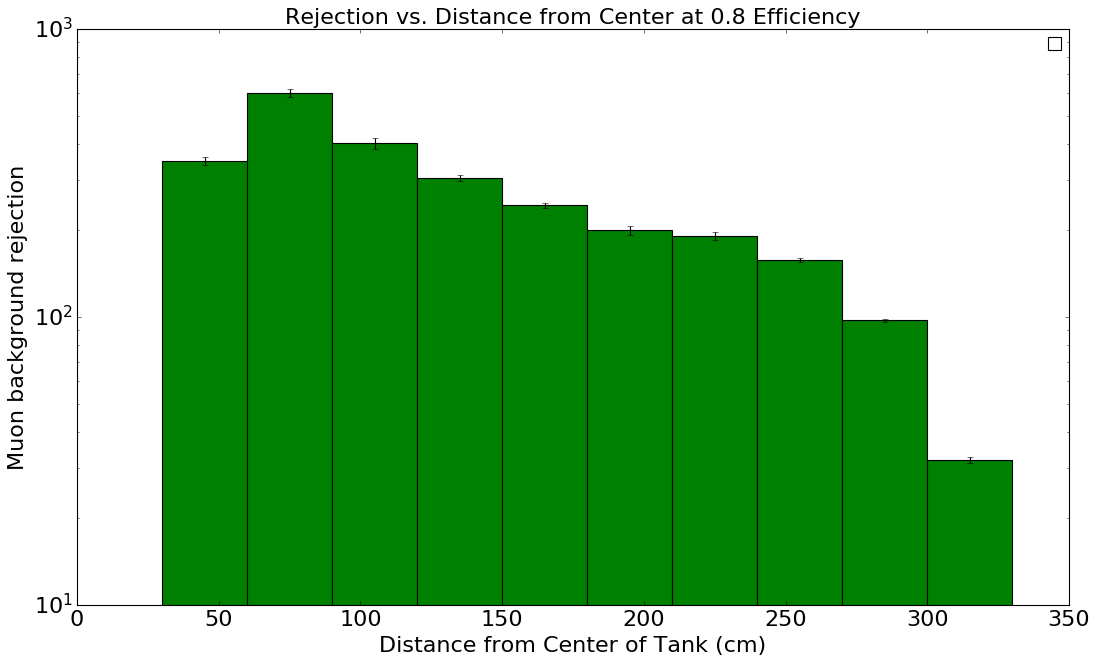

In [43]:
# Make and plot rejection vs. energy bin with fixed efficiency
efficiency = 0.8
fprs = []
tprs = []
thresholds = []

for i in np.arange(len(labels_e_slices)):
    fpr, tpr, threshold = roc_curve(labels_e_slices[i], diff_e_slices[i])
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)
    
# Set up the bins for the histogram 
bins = []
for i in np.arange(len(fprs)):
    bins.append(i*interval)
print(len(bins))
print(bins)
    
curve_metrics = plot_rej_pos(fprs, tprs, thresholds, "e", "mu", 0, 1000, 30, efficiency, bins)

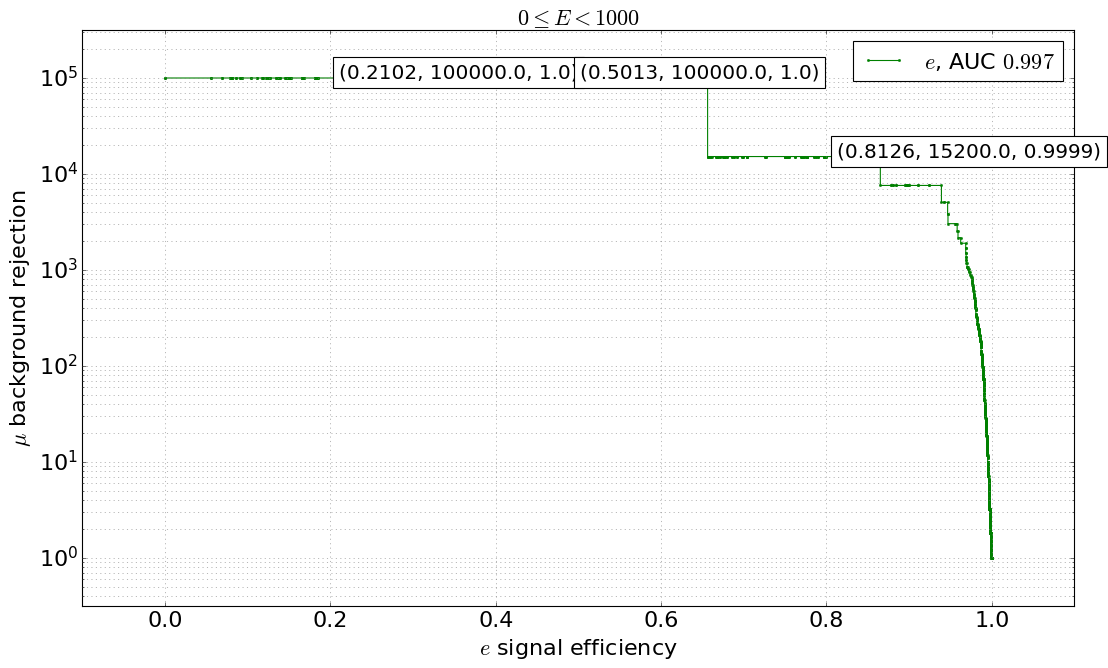

In [77]:
#Make e vs. mu ROC curve for raw nLL differences 
fpr, tpr, threshold = roc_curve(labels_e_slices[-1], diff_e_slices[-1])
roc_metrics = plot_ROC(fpr, tpr, threshold, "e", "mu", 0, 1000, interval=100, step=20)

Text(0.5, 0, 'Energy (MeV)')

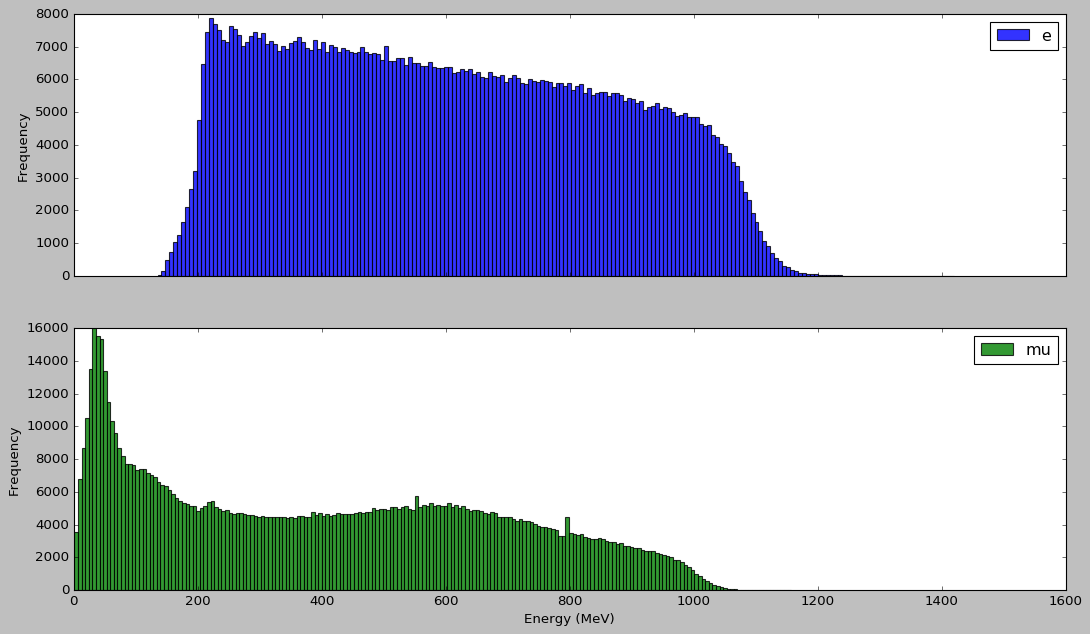

In [18]:
label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}


fig, axes = plt.subplots(2, 1, figsize=(16,9), sharex=True)

label = 0
axes[label].hist(e_mom[:,1], bins=200, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])
axes[label].legend()
axes[label].set_ylabel("Frequency")

plt.xlabel("Energy (MeV)")

label = 1
axes[label].hist(mu_mom[:,0], bins=200, density=False, label=label_dict[label + 1][0], alpha=0.8,
                 color=label_dict[label + 1][1])
axes[label].legend()
axes[label].set_ylabel("Frequency")

plt.xlabel("Energy (MeV)")


In [ ]:
# returns the maximum height at which cherenkov radiation will hit the tank 
def find_dwall(pos, ang, mom):


def find_tdwall(pos, ang, mom):
    # pos - position of particles
    # ang - polar and azimuth angles of particle
    # label - type of particle
    # energy - particle energy
    #label = np.where(label==0, mass_dict[0], label)
    #label = np.where(label==1, mass_dict[1], label)
    #label = np.where(label==2, mass_dict[2], label)
    #beta = ((energy**2 - label**2)**0.5)/energy
    #max_ang = abs(np.arccos(1/(1.33*beta)))*1.5
    max_ang = abs(np.arccos(1/(1.33)))*(1 + abs(pos[:,1]/max(pos[:,1]))*0.5)
    theta = ang[:,1]
    phi = ang[:,0]
    
    # radius of barrel
    r = 400
    end = np.array([pos[:,0], pos[:,2]]).transpose()
    
    # unit vector for particle direction (azimuth)
    # position of particle in barrel
    # a point along particle direction outside of the barrel
    
    start = end + 1000*(np.array([np.cos(theta), np.sin(theta)]).transpose())
    # finding intersection of particle with barrel
    a = (end[:,0] - start[:,0])**2 + (end[:,1] - start[:,1])**2
    b = 2*(end[:,0] - start[:,0])*(start[:,0]) + 2*(end[:,1] - start[:,1])*(start[:,1])
    c = start[:,0]**2 + start[:,1]**2 - r**2
    #t = 2*c / (-b + (b**2 - 4*a*c)**0.5)
    t = (-b - (b**2 - 4*a*c)**0.5)/(2*a)
    intersection = np.array([(end[:,0]-start[:,0])*t,(end[:,1]-start[:,1])*t]).transpose() + start
    length = end - intersection
    length3 = (length[:,0]**2 + length[:,1]**2)**0.5 
    
    length = np.maximum(np.maximum(length1,length2), length3)

    #length[np.isnan(length)]= 5000
    #print(max(length))
    #print(min(length))
    top_ang = math.pi/2 - np.arctan((520 - pos[:,2])/ length)
    bot_ang = math.pi/2 + np.arctan(abs(-520 - pos[:,2])/length)
    #print(top_ang)
    #print(bot_ang)
    lb = top_ang + max_ang
    #print(lb)
    ub = bot_ang - max_ang
    #print(ub)
    return np.array([lb, ub, np.minimum(np.minimum(length1,length2), length3)]).transpose()

In [37]:
print(np.where(np.around(tprs[0], decimals=2) == 0.8)[0].shape)
eff_index = np.where(np.around(tprs[0], decimals=2) == 0.8)[0]
print(fprs[0][eff_index].mean())

(629,)
0.35670064156385606


Text(0.5, 0, 'True Radius from Center (cm^2)')

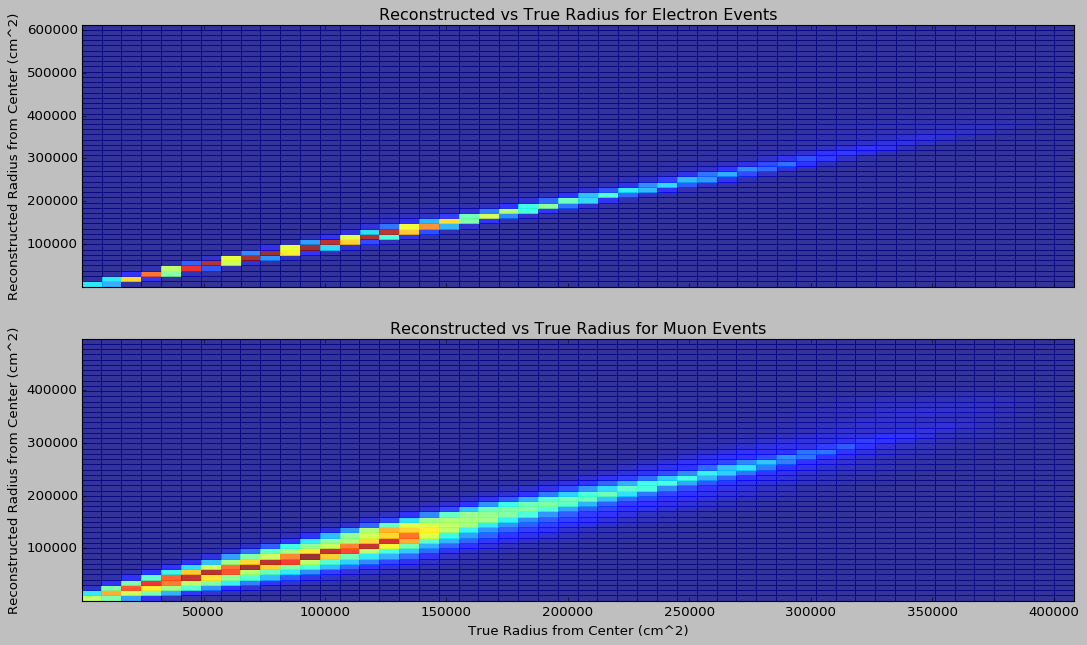

In [44]:
e_true_rad = (e_positions[:,0,0]**2 + e_positions[:,0,1]**2 + e_positions[:,0,2]**2)
e_rec_rad = (e_pos[:,0,0]**2 + e_pos[:,0,1]**2 + e_pos[:,0,2]**2)

mu_true_rad = (mu_positions[:,0,0]**2 + mu_positions[:,0,1]**2 + mu_positions[:,0,2]**2)
mu_rec_rad = (mu_pos[:,0,0]**2 + mu_pos[:,0,1]**2 + mu_pos[:,0,2]**2)


label_dict = {0:["gamma","red"], 1:["e","blue"], 2:["mu","green"]}

fig, axes = plt.subplots(2, 1, figsize=(16,9), sharex=True)

label = 0
axes[label].hist2d(e_true_rad, e_rec_rad, bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Radius from Center (cm^2)")
axes[label].title.set_text('Reconstructed vs True Radius for Electron Events')

plt.xlabel("True Radius from Center (cm^2)")

label = 1
axes[label].hist2d(mu_true_rad, mu_rec_rad, bins=50, density=False, label=label_dict[label + 1][0], alpha=0.8)
#axes[label].legend()
axes[label].set_ylabel("Reconstructed Radius from Center (cm^2)")
axes[label].title.set_text('Reconstructed vs True Radius for Muon Events')

plt.xlabel("True Radius from Center (cm^2)")

In [ ]:
# Dictionary mapping the ordinal labels to particle types 
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}

# Fix the colour scheme for each particle type
COLOR_DICT = {"gamma":"red", "e":"blue", "mu":"green"}

fprs = []
tprs = []
thresholds = []

fpr, tpr, threshold = roc_curve(labels_e, diff_e)
fprs.append(fpr)
tprs.append(tpr)
thresholds.append(threshold)

run_ids = ["20200308_195054"]

dump_dir = "/home/ttuinstr/VAE/dumps/"
dump_file = "/test_validation_iteration_dump.npz"

softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

for run_id in run_ids:
    
    test_dump_path = dump_dir + run_id + dump_file
    test_dump_np = np.load(test_dump_path)
    
    softmaxes  = test_dump_np['softmax'].reshape(-1, 3)
    labels   = test_dump_np['labels'].reshape(-1)
    energies = test_dump_np['energies'].reshape(-1)
    
    label_0 = "e"
    label_1 = "mu"
    min_energy = 0
    max_energy = 1000
    #------------------------------------------------------------------------
    # Create a boolean map to select events in the user-defined energy range
    #------------------------------------------------------------------------
    
    energy_slice_map = [False for i in range(len(energies))]
    
    for i in range(len(energies)):
        if(energies[i] >= min_energy and energies[i] < max_energy):
                energy_slice_map[i] = True
                
    curr_softmax = softmaxes[energy_slice_map]
    curr_labels = labels[energy_slice_map]
    curr_energies = energies[energy_slice_map]
    
    #------------------------------------------------------------------------
    # Extract the softmax and true label values for signal and background events
    #------------------------------------------------------------------------
    
    # Extract the useful softmax and labels from the input arrays
    softmax_0 = curr_softmax[curr_labels==softmax_index_dict[label_0]]
    labels_0 = curr_labels[curr_labels==softmax_index_dict[label_0]]
    energies_0 = curr_energies[curr_labels==softmax_index_dict[label_0]]
    
    softmax_1 = curr_softmax[curr_labels==softmax_index_dict[label_1]]
    labels_1 = curr_labels[curr_labels==softmax_index_dict[label_1]]
    energies_1 = curr_energies[curr_labels==softmax_index_dict[label_1]]
    
    # Add the two arrays
    softmax = np.concatenate((softmax_0, softmax_1), axis=0)
    labels = np.concatenate((labels_0, labels_1), axis=0)

    #------------------------------------------------------------------------
    # Compute the ROC curve and the AUC for class corresponding to label 0
    #------------------------------------------------------------------------
    
    fpr, tpr, threshold = roc_curve(labels, softmax[:,softmax_index_dict[label_0]], pos_label=softmax_index_dict[label_0])
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)

#roc_metrics = plot_multiple_ROC(fprs, tprs, thresholds, "e", "mu", 0, 1000)
